# Usage of the Event Detector by Liu et al.

# Load the required packages

In [1]:
# Import public packages
import sys
import os
from pathlib import Path
import ipdb
from matplotlib import pyplot as plt
import glob
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from io import StringIO

# Add src to the path for import
project_dir = Path(os.getcwd()).resolve().parents[0]
module_path = os.path.abspath(os.path.join(project_dir))  
if module_path not in sys.path:
    sys.path.append(module_path)

# Import private source code
from Event_Detectors import EventDet_Liu_Ripple

# Activate Autoreload
%load_ext autoreload
%autoreload 2

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


# Set all global Parameters for the BLUED Dataset

In [17]:
# Hardcoded Hyperparameters
DATASET_LOCATION_BLUED = os.path.join("./Test_Data/") #Path to Test Data
CURRENT_COLUMN = "Current B"
NETWORK_FREQUENCY_BLUED = 60
SAMPLES_PER_SECOND_BLUED = NETWORK_FREQUENCY_BLUED #because we compute period wise datapoints
SAMPLERATE_BLUED = 12000

# For the event detector
init_dict_BLUED = {"median_filter_window" : 9,
"q_ripple_window_size" : 10, 
"power_threshold" : 10, 
"perform_input_order_checks": True,
"window_size_n" : 5 * 21 #5 times the q_ripple_window_size is an assumption
                 } 


SAMPLES_FEATURE_PER_WINDOW_BLUED = init_dict_BLUED["window_size_n"]
WINDOW_SIZE_SECONDS_BLUED = SAMPLES_FEATURE_PER_WINDOW_BLUED / SAMPLES_PER_SECOND_BLUED

# Compute how big the window is regarding the raw samples --> this is used for the streamiong
samples_raw_per_window_BLUED = SAMPLERATE_BLUED *  WINDOW_SIZE_SECONDS_BLUED
seconds_per_feature_sample = 1 / SAMPLES_PER_SECOND_BLUED
BLUED_period = int(SAMPLERATE_BLUED / NETWORK_FREQUENCY_BLUED) 


# Load and display the BLUED Test File

In [3]:
def load_file_BLUED(file_path, phase="b"):
    """
    Function to load the BLUED test data.
     Args:
            file_path (Path): full path to the test file
            phase (string): either "all", "b" or "a". Returns only the requested phase of the dataset.

    Returns:
            data_df (pandas DataFrame): original columns if phase=="all" else colums are just "Current" and "Voltage" --> already for the matching phase! (* - 1 done for B)
            file_info (dict): dictionary with information about the file that was loaded. Parsed from the filename
            and the metadata included in the file.
    """
    with open(file_path, 'r') as f:

            data_txt = f.read()

            lines = data_txt.splitlines()

            data_txt = data_txt.split("***End_of_Header***")
            reference_time = data_txt[0].split("Date,")[1][:11].replace("\n","") +"-"+ data_txt[0].split("Time,")[1][:15]
            reference_time = datetime.strptime(reference_time, '%Y/%m/%d-%H:%M:%S.%f')


            data_time_str = data_txt[1].split("Time,")[1]
            data_time_str = data_time_str.split(',')

            data_day_str = data_txt[1].split("Date,")[1]
            data_day_str = data_day_str.split(',')

            day_str = data_day_str[0]  # just the first on is enoguh
            time_str = data_time_str[0][:15]  # same for time
            date = day_str + "-" + time_str
            start_date_time = datetime.strptime(date, '%Y/%m/%d-%H:%M:%S.%f')

            filename = Path(file_path).name  # get the file name

            samples = data_txt[1].split("Samples,")[1].split(",")[0:3][0]
            samples = int(samples)

            values_str = data_txt[-1]
            values_str = values_str[values_str.index("X_Value"):]

            measurement_steps = data_txt[1].split("Delta_X")[1].split(",")[0:3]
            measurement_steps = [float(x) for x in measurement_steps if x != ""]
            measurement_steps = measurement_steps[0]

            data_df = pd.read_csv(StringIO(values_str), usecols=["X_Value", "Current A", "Current B", "VoltageA"])

            data_df.dropna(inplace=True,how="any")
           
            file_duration = data_df.tail(1)["X_Value"].values[0]
            file_duration = float(file_duration)

            file_duration = timedelta(seconds=file_duration)
            end_date_time = reference_time + file_duration

            file_duration = end_date_time - start_date_time

            # Convert totimestamps
            data_df["TimeStamp"] = data_df["X_Value"].apply(lambda x: timedelta(seconds=x) + reference_time)
            data_df.drop(columns=["X_Value"],inplace=True)
            data_df.set_index("TimeStamp",inplace=True)

            file_info = {"Filepath": file_path, "Filename": filename, "samples": samples,
                         "file_start": start_date_time, "file_duration": file_duration, "file_end": end_date_time,
                         "measurement_steps": measurement_steps,"reference_time":reference_time}

            if phase.lower() != "all":
                if phase.lower() == "a":
                    data_df["Current"] = data_df["Current A"]
                    data_df["Voltage"] = data_df["VoltageA"]
                elif phase.lower() == "b":
                    data_df["Current"] = data_df["Current B"]
                    data_df["Voltage"] = data_df["VoltageA"].values * -1
                else:
                    raise ValueError("The phase provided does not exist")

                data_df.drop(columns=['Current A', 'Current B',"VoltageA"],inplace=True)

    return data_df, file_info

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


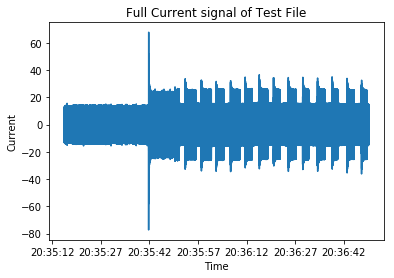

In [4]:
# Get the Test File
test_file = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.txt"))[0] #get the full path of the test file

# Load the Data from the test File
data,file_info = load_file_BLUED(test_file)

current = data["Current"]
voltage = data["Voltage"]

# Plot the data from the test File
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")
plt.plot(current)
plt.show()


# Run the Event Detection on the Test Data

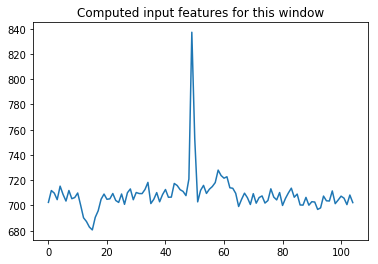

+++++++++++++++++++++++++++++++++++


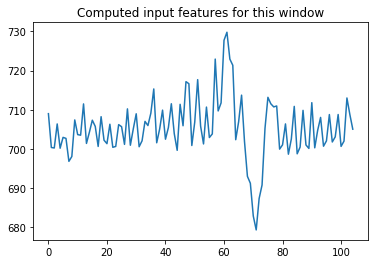

+++++++++++++++++++++++++++++++++++


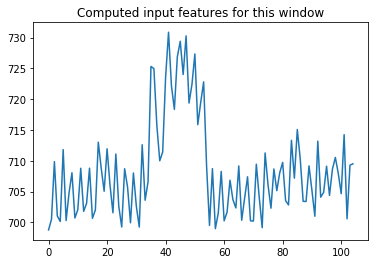

+++++++++++++++++++++++++++++++++++


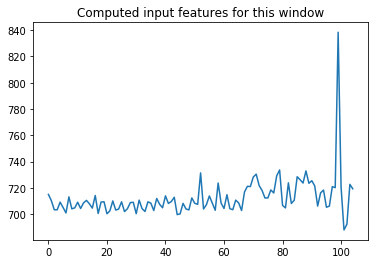

+++++++++++++++++++++++++++++++++++


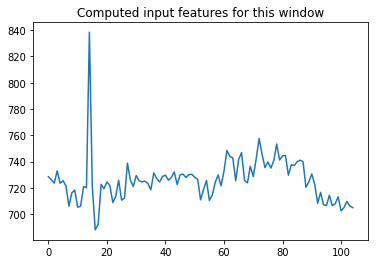

+++++++++++++++++++++++++++++++++++


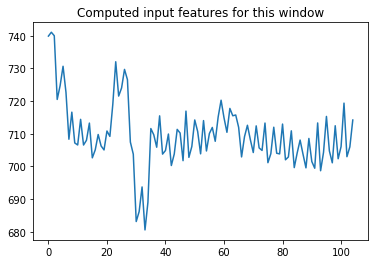

+++++++++++++++++++++++++++++++++++


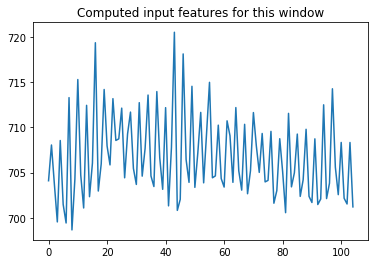

+++++++++++++++++++++++++++++++++++


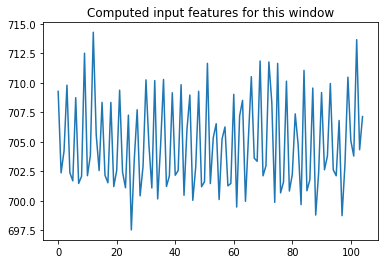

+++++++++++++++++++++++++++++++++++


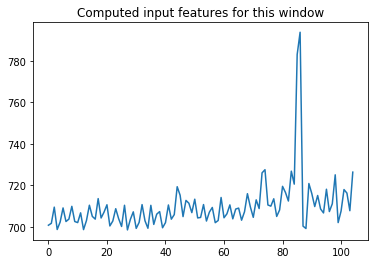

+++++++++++++++++++++++++++++++++++


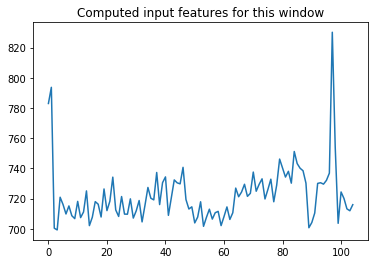

+++++++++++++++++++++++++++++++++++


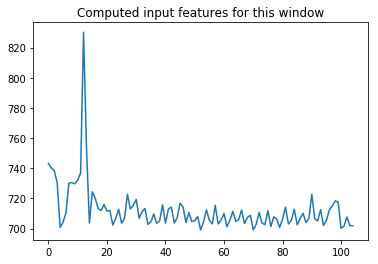

+++++++++++++++++++++++++++++++++++


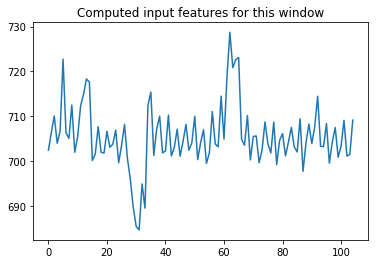

+++++++++++++++++++++++++++++++++++


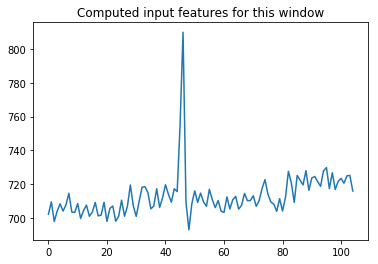

+++++++++++++++++++++++++++++++++++


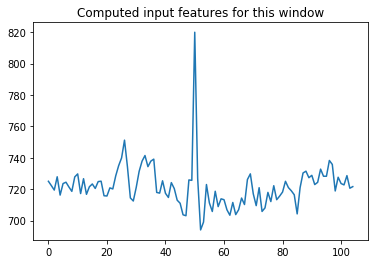

+++++++++++++++++++++++++++++++++++


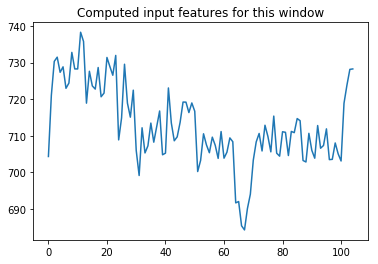

+++++++++++++++++++++++++++++++++++


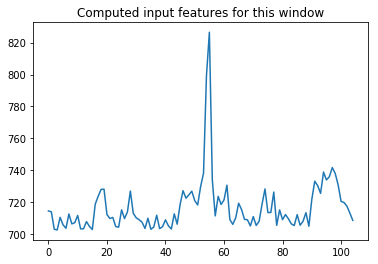

+++++++++++++++++++++++++++++++++++


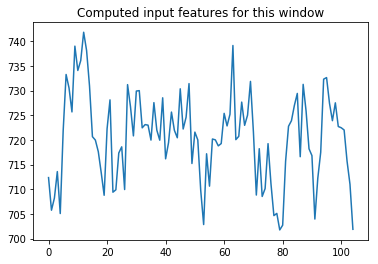

+++++++++++++++++++++++++++++++++++


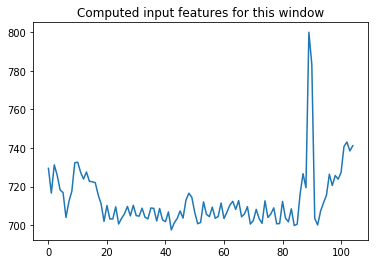

+++++++++++++++++++++++++++++++++++


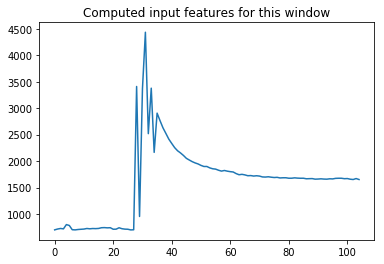

Event Detected at 2011-10-23 20:35:46.223499
+++++++++++++++++++++++++++++++++++


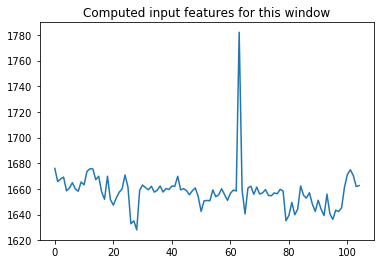

+++++++++++++++++++++++++++++++++++


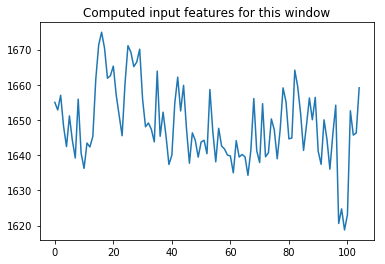

Event Detected at 2011-10-23 20:35:45.990166
+++++++++++++++++++++++++++++++++++


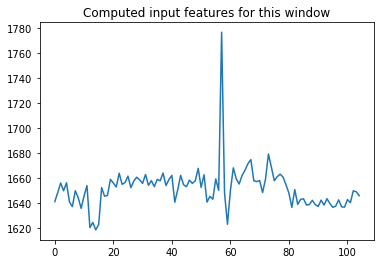

+++++++++++++++++++++++++++++++++++


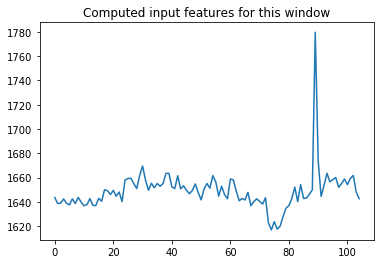

+++++++++++++++++++++++++++++++++++


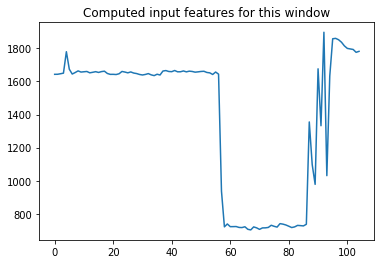

Event Detected at 2011-10-23 20:35:46.706832
+++++++++++++++++++++++++++++++++++


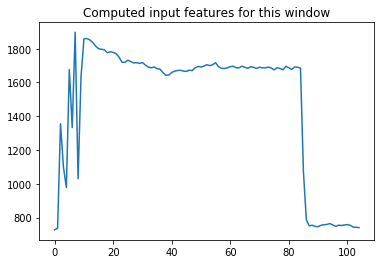

Event Detected at 2011-10-23 20:35:45.956832
Event Detected at 2011-10-23 20:35:47.173499
+++++++++++++++++++++++++++++++++++


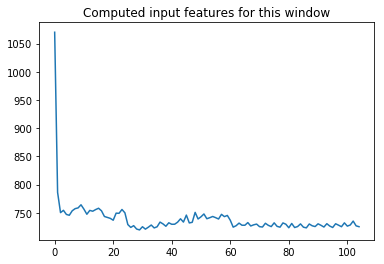

+++++++++++++++++++++++++++++++++++


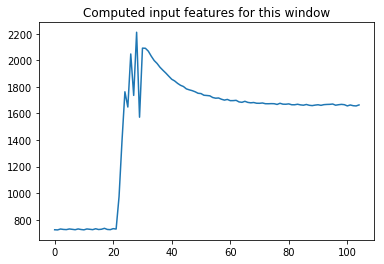

Event Detected at 2011-10-23 20:35:46.123499
+++++++++++++++++++++++++++++++++++


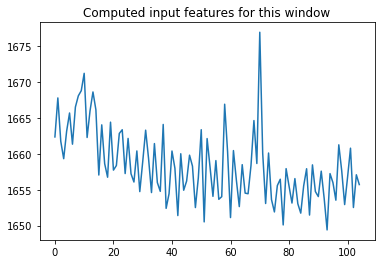

+++++++++++++++++++++++++++++++++++


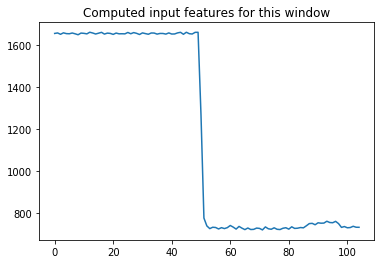

Event Detected at 2011-10-23 20:35:46.590166
+++++++++++++++++++++++++++++++++++


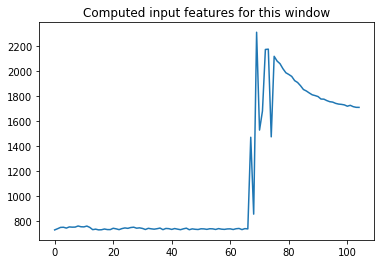

Event Detected at 2011-10-23 20:35:46.873499
+++++++++++++++++++++++++++++++++++


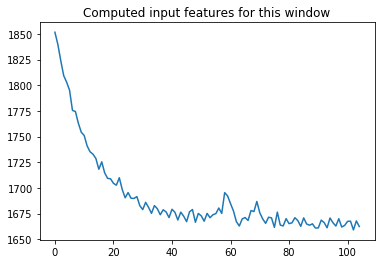

Event Detected at 2011-10-23 20:35:45.940166
+++++++++++++++++++++++++++++++++++


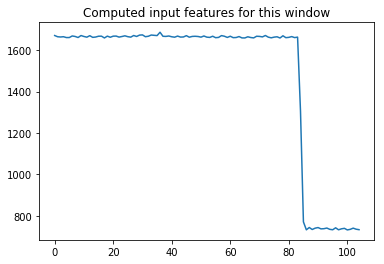

Event Detected at 2011-10-23 20:35:47.156832
+++++++++++++++++++++++++++++++++++


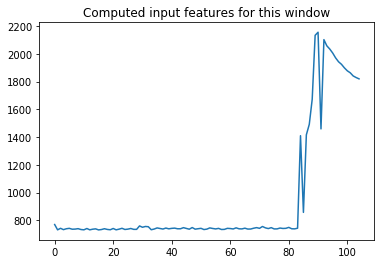

Event Detected at 2011-10-23 20:35:47.156832
+++++++++++++++++++++++++++++++++++


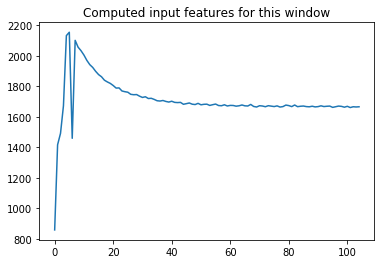

Event Detected at 2011-10-23 20:35:45.940166
+++++++++++++++++++++++++++++++++++


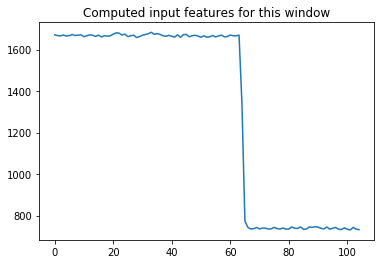

Event Detected at 2011-10-23 20:35:46.823499
+++++++++++++++++++++++++++++++++++


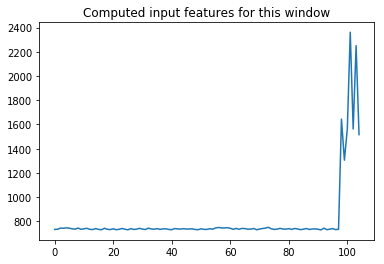

+++++++++++++++++++++++++++++++++++


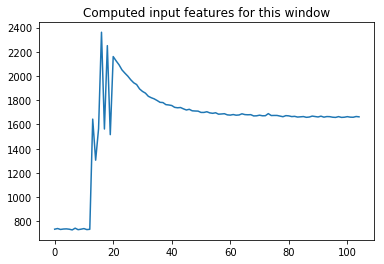

Event Detected at 2011-10-23 20:35:45.973499
+++++++++++++++++++++++++++++++++++


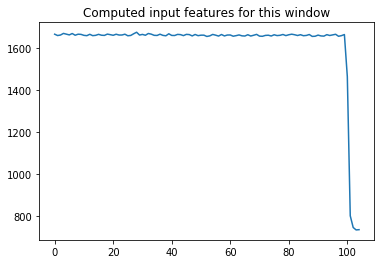

+++++++++++++++++++++++++++++++++++


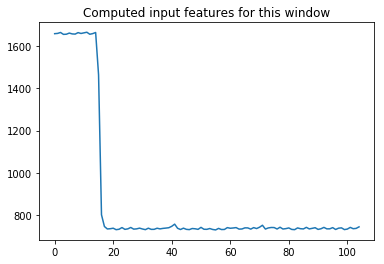

Event Detected at 2011-10-23 20:35:46.006832
+++++++++++++++++++++++++++++++++++


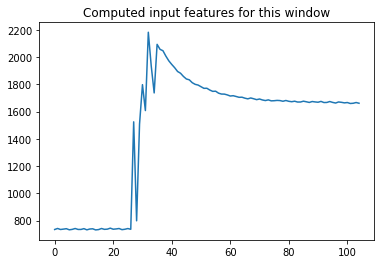

Event Detected at 2011-10-23 20:35:46.206832
+++++++++++++++++++++++++++++++++++


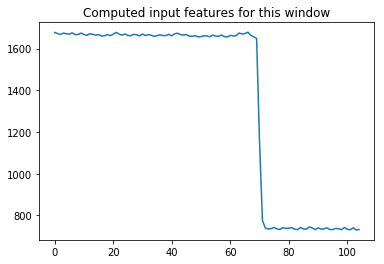

Event Detected at 2011-10-23 20:35:46.906832
+++++++++++++++++++++++++++++++++++


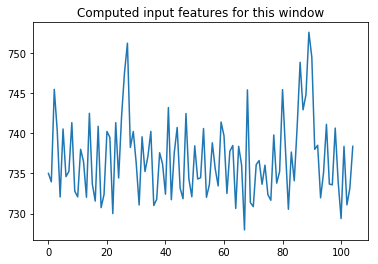

+++++++++++++++++++++++++++++++++++


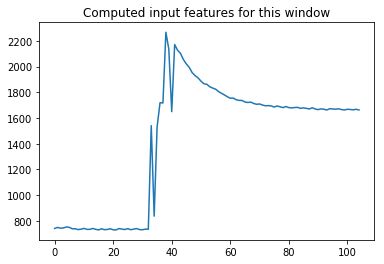

Event Detected at 2011-10-23 20:35:46.306832
+++++++++++++++++++++++++++++++++++


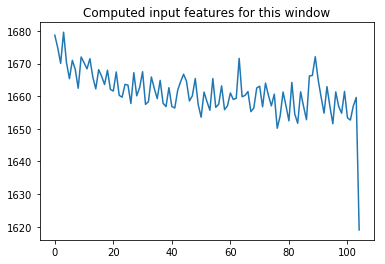

+++++++++++++++++++++++++++++++++++


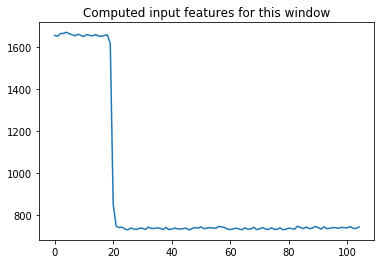

Event Detected at 2011-10-23 20:35:46.073499
+++++++++++++++++++++++++++++++++++


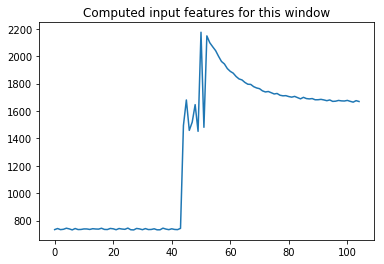

Event Detected at 2011-10-23 20:35:46.490166
+++++++++++++++++++++++++++++++++++


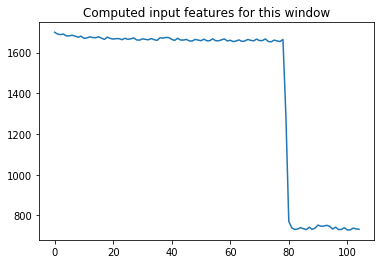

Event Detected at 2011-10-23 20:35:47.073499
+++++++++++++++++++++++++++++++++++


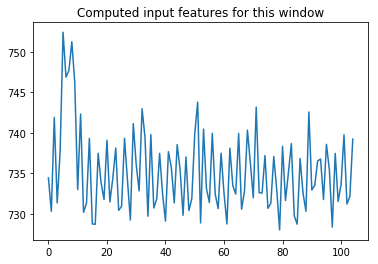

+++++++++++++++++++++++++++++++++++


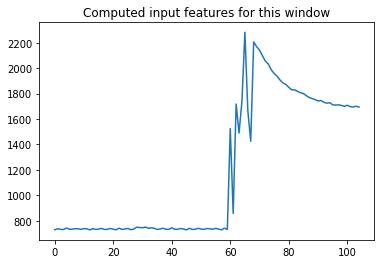

Event Detected at 2011-10-23 20:35:46.756832
+++++++++++++++++++++++++++++++++++


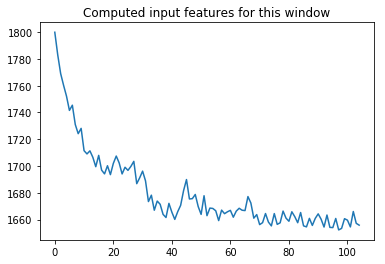

Event Detected at 2011-10-23 20:35:46.290166
+++++++++++++++++++++++++++++++++++


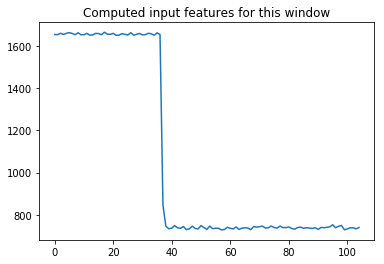

Event Detected at 2011-10-23 20:35:46.373499
+++++++++++++++++++++++++++++++++++


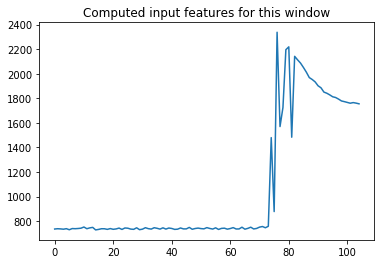

Event Detected at 2011-10-23 20:35:46.990166
+++++++++++++++++++++++++++++++++++


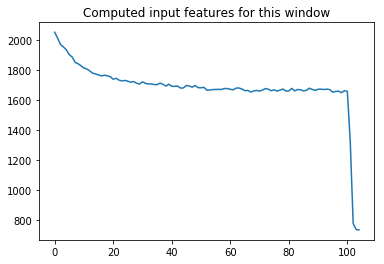

Event Detected at 2011-10-23 20:35:45.940166
+++++++++++++++++++++++++++++++++++


In [27]:
samples_remaining = len(current) # number of samples that we have not predicted yet
window_start = 0 # offset of the next window

# Step 1: Initialize  the Event Detector with the Hypperparameter dictionary 
Liu = EventDet_Liu_Ripple(**init_dict_BLUED) #i.e. values are unpacked into the parameters
Liu.fit() # Call the fit() method to further initialize the algorithm (required by the sklearn API)

# As we will stream overlapping windows with a relative offset to each other we set this here
relative_offset = Liu.q_ripple_window_size * 2 # is 2q and -1 because we need it to be negative
relative_offset = (relative_offset / 60) * SAMPLERATE_BLUED # convert the relative offset that is relative to the feature domain
# to the relative offset for the raw input domain. 
# we devide by 60 as we have 60 feature points per second to get the number of seconds and then we multpily by the sampling rate
# to get the number of raw samples required.

while samples_remaining >= samples_raw_per_window_BLUED: #while we still have samples to "stream" do the following
    
    window_stop = int(window_start + samples_raw_per_window_BLUED) # compute end index of the new window
    window_start_timestamp = file_info["file_start"] + timedelta(seconds=30) #first 30 seconds used for training

    # Get the voltage and current windows
    voltage_window = voltage[window_start:window_stop]
    current_window = current[window_start:window_stop]

    # Step 2: Use the feature computation function of the algorithm to compute the input features
    X = Liu.compute_input_signal(voltage=voltage_window, current=current_window, period_length=BLUED_period) 
    
    # Plot the computed features
    plt.title("Computed input features for this window")
    plt.plot(X)
    plt.show()
    
    # Step 3: Run the prediciton on the features
    events = Liu.predict(X) 

    if len(events) > 0: # if an event is returned
        
        event_timestamps = []
        # Convert indices to timestamps for the postprocessing
        for event_index in events:
            event_timestamps.append(window_start_timestamp + timedelta(seconds=event_index * seconds_per_feature_sample))
            
        # As the algorithm is very sensitive, we have applied postprocessing like the other reference algorithms
        # to filter out events that are detected within a certain time limit, i.e. here 1 second.
        # so events that fall within this timeframe are treated as one event.
        events_postprocessed = Liu.event_list_postprocessing(event_timestamps, postprocessing_limit=1)
        
        if len(events_postprocessed)>0:
            for event in events_postprocessed:
                print("Event Detected at " + str(event))
        
      
        
    # We start at the end of the previous window
    window_start = int(window_stop - relative_offset)
    print("+++++++++++++++++++++++++++++++++++")
    
    # We need to update the data points that remain for streaming now.
    samples_remaining -= samples_raw_per_window_BLUED
    